<a href="https://colab.research.google.com/github/isaachfp/bi-master/blob/master/RN_Trabalho/RedesRecorrentespul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [127]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

### Importar a base de dados

In [128]:
dataset_train = pd.read_csv('train.csv')
dataset_train.head()

,index,value
0,1974 Jan,3035
1,1974 Feb,2552
2,1974 Mar,2704
3,1974 Apr,2554
4,1974 May,2014


In [129]:
training_set = dataset_train.iloc[:, 1:2].values #só coluna da série em si

### gráfico da série temporal

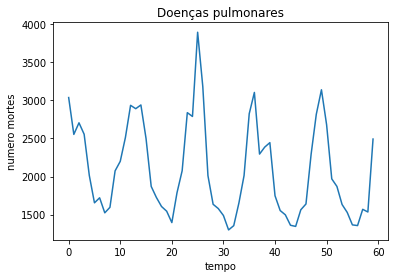

In [130]:
plt.plot(training_set)
plt.xlabel("tempo")
plt.ylabel("numero mortes")
plt.title("Doenças pulmonares")
plt.show()

### Normalização

In [131]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [132]:
window = 15
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [133]:
X_train.shape

(45, 15)

In [134]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [135]:
X_train.shape

(45, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [136]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [137]:
#hidden_nodes = int(2/3 * (X_train.shape[0] + 1))
#print(hidden_nodes)

### Construção da Rede completa

In [138]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = False))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 50))
#regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 15, 100)           40800     
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 100)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 80)                57920     
_________________________________________________________________
dropout_14 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 81        
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


### Treinamento

In [139]:
regressor.fit(X_train, y_train, epochs = 250, batch_size = 64)

Epoch 1/250
45/45 [==============================] - 1s 21ms/step - loss: 0.1306
Epoch 2/250
45/45 [==============================] - 0s 804us/step - loss: 0.0985
Epoch 3/250
45/45 [==============================] - 0s 911us/step - loss: 0.0768
Epoch 4/250
45/45 [==============================] - 0s 750us/step - loss: 0.0629
Epoch 5/250
45/45 [==============================] - 0s 764us/step - loss: 0.0570
Epoch 6/250
45/45 [==============================] - 0s 759us/step - loss: 0.0661
Epoch 7/250
45/45 [==============================] - 0s 796us/step - loss: 0.0745
Epoch 8/250
45/45 [==============================] - 0s 823us/step - loss: 0.0678
Epoch 9/250
45/45 [==============================] - 0s 814us/step - loss: 0.0629
Epoch 10/250
45/45 [==============================] - 0s 860us/step - loss: 0.0580
Epoch 11/250
45/45 [==============================] - 0s 799us/step - loss: 0.0569
Epoch 12/250
45/45 [==============================] - 0s 811us/step - loss: 0.0606
Epoch 13/250
4

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [140]:
dataset_test = pd.read_csv('test.csv')
test_pul = dataset_test.iloc[:, 1:2].values

### Construir a estrutura para teste

In [141]:
dataset_total = pd.concat((dataset_train.iloc[:,1], dataset_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [142]:
predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

### Visualizar os resultados de treino e teste

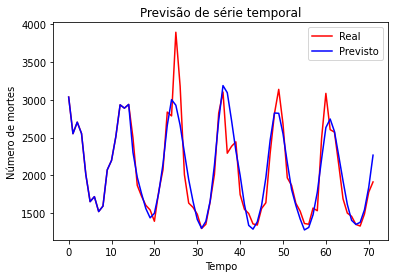

In [143]:
allTargetData = np.vstack((training_set, test_pul))
training_predicted = regressor.predict(X_train)
training_predicted = sc.inverse_transform(training_predicted)
allForecastedData = np.vstack((training_set[0:window], training_predicted, predicted))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Número de mortes')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [144]:
import math
from sklearn.metrics import mean_squared_error,r2_score
rmse = math.sqrt(mean_squared_error(test_pul, predicted))
print('RMSE: ', rmse)

RMSE:  192.19686890089795


In [145]:
mse = mean_squared_error(test_pul, predicted)
print('MSE: ',mse)

MSE:  36939.63641530896


In [146]:
mape = np.mean(np.abs((test_pul - predicted) / test_pul)) * 100
print('MAPE: ',mape, '%')

MAPE:  6.696700033176538 %


In [147]:
r2 = r2_score(test_pul,predicted, )
print('R2: ', r2)

R2:  0.8769401079356179
